# Introduction
    
   Online payment is the most popular transaction method in the world today. However, with an increase in online payments also comes a rise in payment fraud. The objective of this study is to identify fraudulent and non-fraudulent payments.

## Importing libraries

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
from joblib import dump,load
import os
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [2]:
df=pd.read_csv('Dataset/onlinefraud.csv')

In [12]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4631162,329,CASH_IN,71846.94,C1437782961,10252983.66,10324830.60,C1491439677,187450.67,115603.73,0,0
3545975,260,PAYMENT,5402.40,C57831511,0.00,0.00,M1538611557,0.00,0.00,0,0
2153757,184,CASH_OUT,133158.14,C600437537,0.00,0.00,C2037389094,751578.78,884736.92,0,0
2338067,189,CASH_IN,136505.01,C1452622752,7223.00,143728.01,C140725940,1953826.08,1817321.07,0,0
4199339,305,CASH_OUT,122170.23,C1422678517,0.00,0.00,C1449372072,549817.90,671988.13,0,0
5102600,355,CASH_OUT,158911.98,C1167664215,0.00,0.00,C1744617229,2712209.95,2871121.92,0,0
296939,15,CASH_OUT,23035.88,C536073414,24659.00,1623.12,C2007648376,992409.65,930943.08,0,0
1455730,140,CASH_OUT,11502.48,C1396791883,51930.00,40427.52,C608655851,139942.67,151445.16,0,0
439167,18,PAYMENT,6482.44,C1206096012,10030.00,3547.56,M596888581,0.00,0.00,0,0
4808795,346,PAYMENT,24878.62,C845852602,0.00,0.00,M340026247,0.00,0.00,0,0


In [14]:
df.shape

(6362620, 11)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [16]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Checking for missing values

In [17]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Exploratory Analysis and Visualization

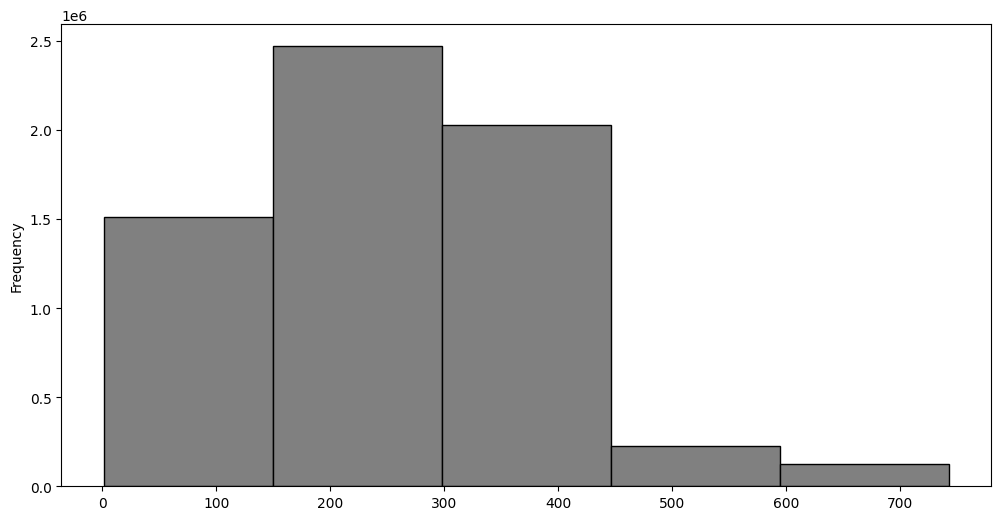

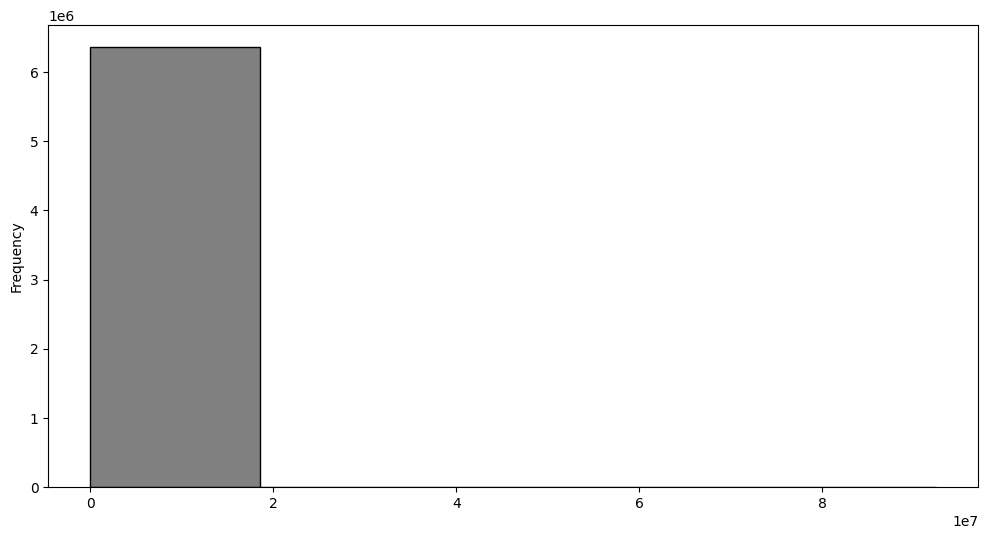

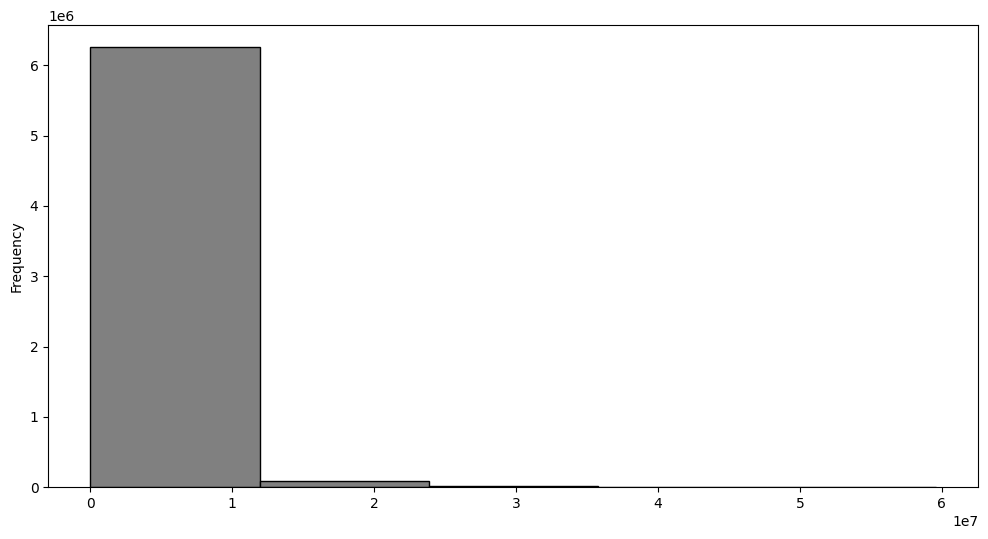

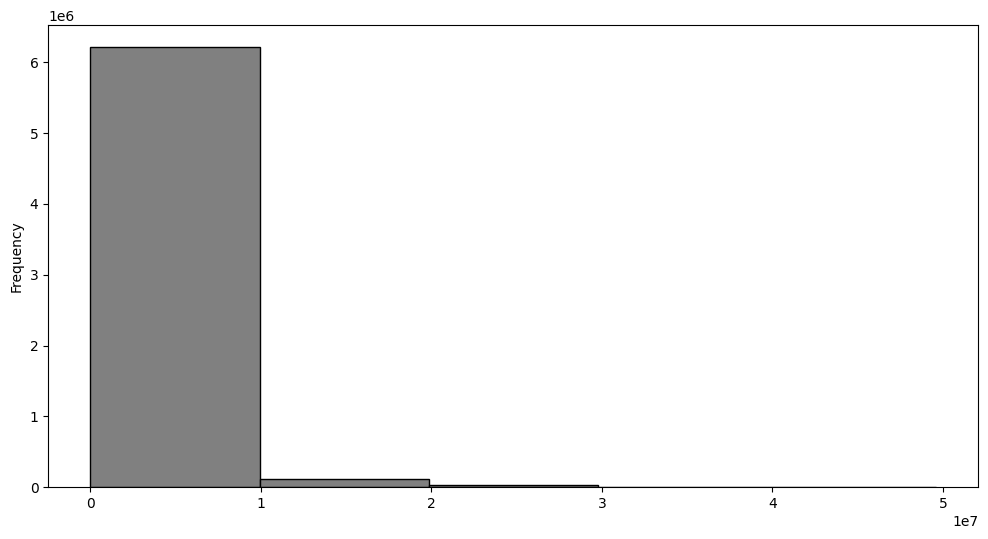

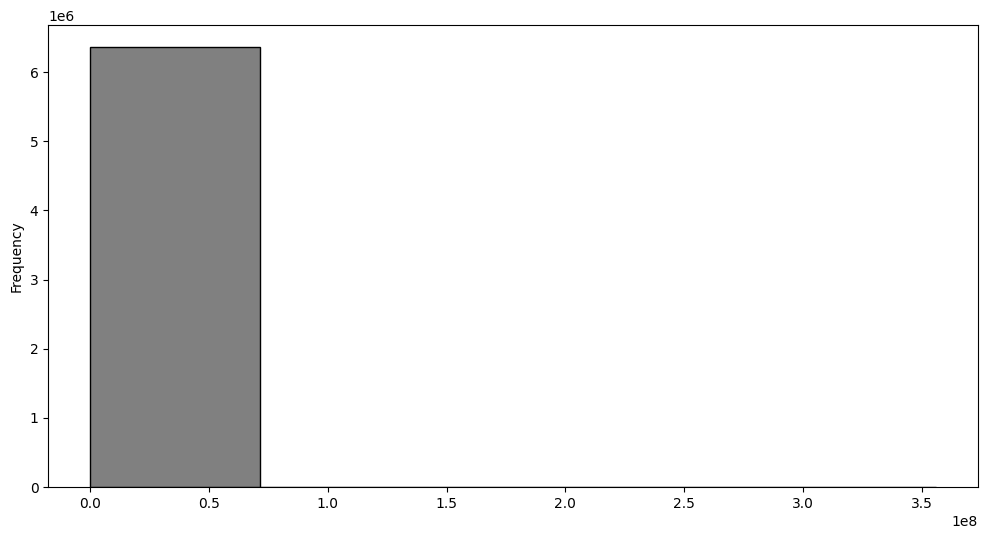

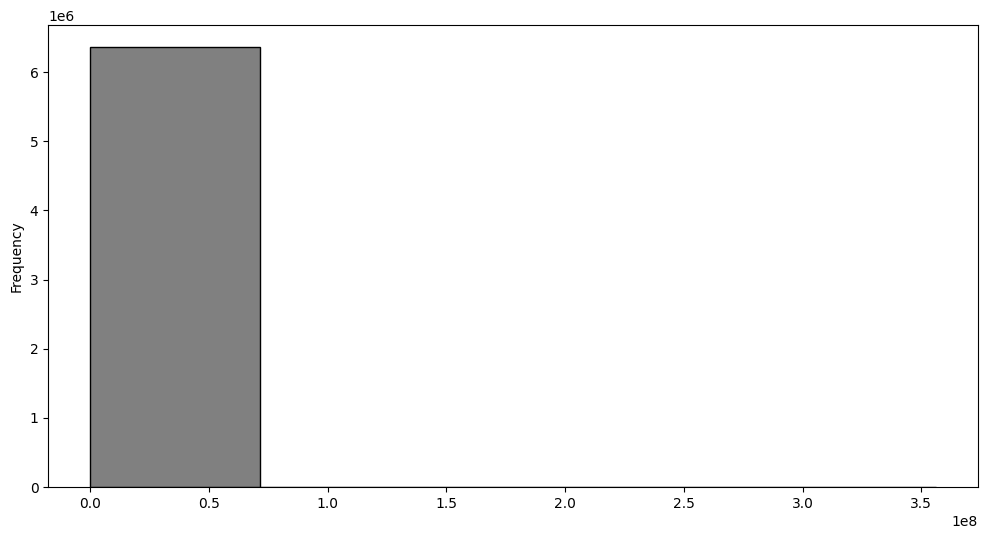

In [18]:
feature=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
for i in feature:
    plt.xlabel(i)
    df[i].plot(kind='hist', bins=5, figsize=(12,6), facecolor='grey',edgecolor='black')
    plt.show()

In [19]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
for i in feature:
    lower = df[i].quantile(0.10)
    upper = df[i].quantile(0.90)
    df[i] = np.where(df[i] <lower, lower,df[i])
    df[i] = np.where(df[i] >upper, upper,df[i])
    print('Feature: ',i)
    print('Skewness value: ',df[i].skew())
    print('\n')

Feature:  amount
Skewness value:  0.8046460444556197


Feature:  oldbalanceOrg
Skewness value:  2.249361299814406


Feature:  newbalanceOrig
Skewness value:  2.2262847493216786


Feature:  oldbalanceDest
Skewness value:  1.4173123924260833


Feature:  newbalanceDest
Skewness value:  1.3593024983493058




### Looking into type column for type of transaction done

df.type.unique()

In [20]:
payment = df.type.value_counts()
payment

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

<Axes: ylabel='type'>

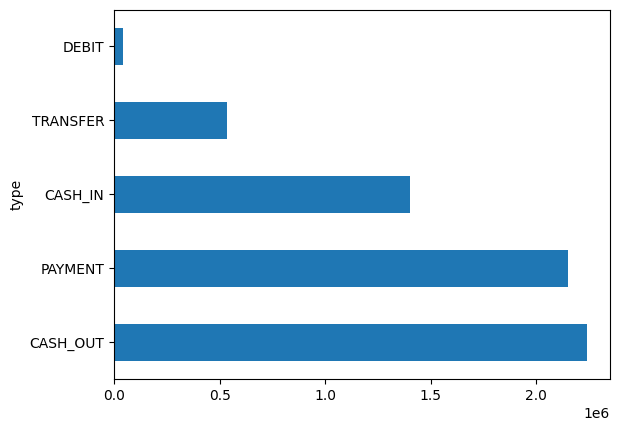

In [21]:
payment.plot(kind='barh')

<Axes: xlabel='type', ylabel='count'>

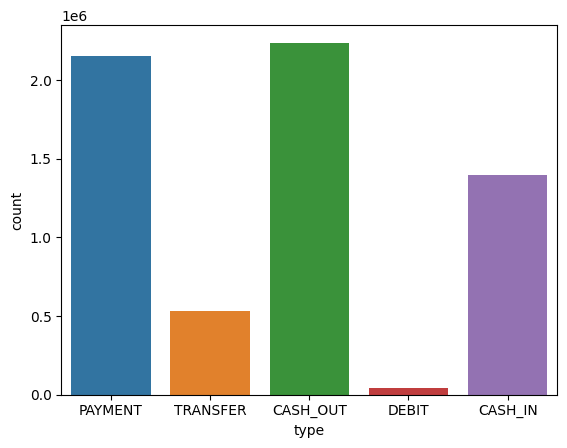

In [22]:
sns.countplot(x='type', data=df)

In [23]:
CrosstabResult=pd.crosstab(index=df.type,columns=df.isFraud)
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


<Axes: xlabel='type'>

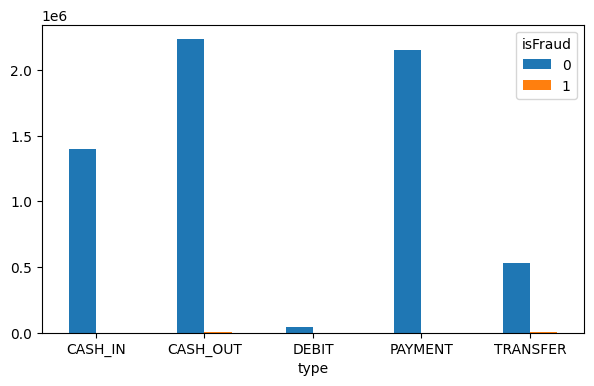

In [24]:
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

### percentage of frauds in cash_out type

In [25]:
cashout=2233384+4116
cashout_fraud= 4116/(cashout) * 100
cashout_fraud

0.18395530726256984

### Percentage of frauds in transfer type

In [26]:
transfer= 528812+4097
transfer_fraud = 4097/(transfer) * 100
transfer_fraud

0.7687991758442811

### looking into amount column

In [27]:
df.amount

0            9839.640
1            4501.300
2            4501.300
3            4501.300
4           11668.140
              ...    
6362615    339682.130
6362616    365423.309
6362617    365423.309
6362618    365423.309
6362619    365423.309
Name: amount, Length: 6362620, dtype: float64

In [28]:
print('Minimum: ',df.amount.min())
print('Maximum: ',df.amount.max())

Minimum:  4501.3
Maximum:  365423.30900000007


### the relationship of amount column with isFraud column

<Axes: title={'center': 'amount'}, xlabel='isFraud'>

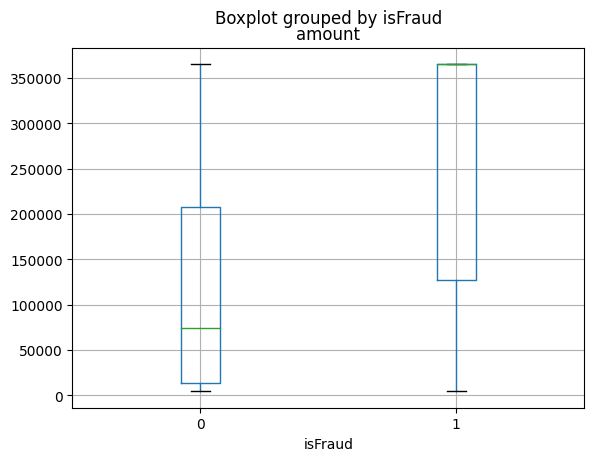

In [29]:
df.boxplot(column='amount', by='isFraud')

Fraud amount transaction range is between 1.3-3.6 lakh

### Looking into isFraud column

In [30]:
total_transactions = df.shape[0]

fraud_transaction = df[df.isFraud==1].shape[0]

fraud_percent= fraud_transaction/total_transactions * 100
fraud_percent

0.12908204481801522

In [31]:
print('Total transactions: ',total_transactions)
print('Total fraud transactions happened: ',fraud_transaction)
print("Total fraud transaction percent: ",round(fraud_percent,2))

Total transactions:  6362620
Total fraud transactions happened:  8213
Total fraud transaction percent:  0.13


In [32]:
fraud_amount= df[df.isFraud==1]
fraud_amount=fraud_amount.sort_values(by=['amount'],ascending=False)
fraud_amount

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5188057,367,CASH_OUT,365423.309,C1210833971,435867.160,0.000,C363013236,186826.40,622693.550,1,0
5990227,416,CASH_OUT,365423.309,C2110305720,1822508.289,0.000,C225008798,523626.59,3194869.671,1,0
5990225,416,CASH_OUT,365423.309,C246726057,1822508.289,0.000,C1786144514,2423749.18,3194869.671,1,0
5990224,416,TRANSFER,365423.309,C298387535,1822508.289,1970344.793,C662194461,0.00,0.000,1,0
5988262,415,CASH_OUT,365423.309,C2137951962,1675153.280,0.000,C309573869,12832.26,1687985.530,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6002113,428,CASH_OUT,4501.300,C1838531308,3037.670,0.000,C505532836,800854.71,803892.380,1,0
6002112,428,TRANSFER,4501.300,C1408814433,3037.670,0.000,C944070846,0.00,0.000,1,0
1796322,162,TRANSFER,4501.300,C1172437299,151.000,0.000,C315826176,0.00,0.000,1,0
1796323,162,CASH_OUT,4501.300,C790340353,151.000,0.000,C517676411,386163.34,386314.340,1,0


In [33]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: xlabel='step', ylabel='Density'>

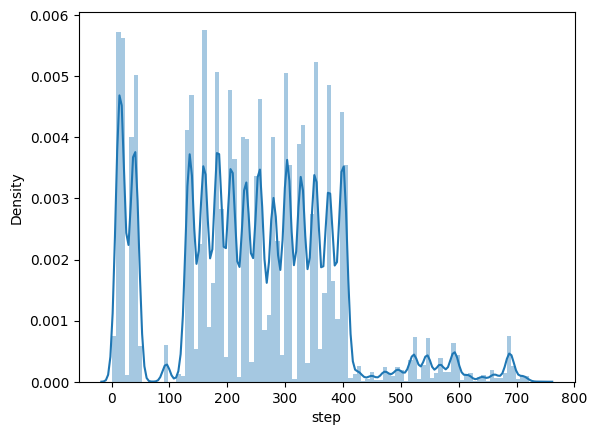

In [26]:
sns.distplot(df['step'], bins=100)

###### Correlation between features

In [34]:
numeric_df = df.select_dtypes(include=['number'])

<Axes: >

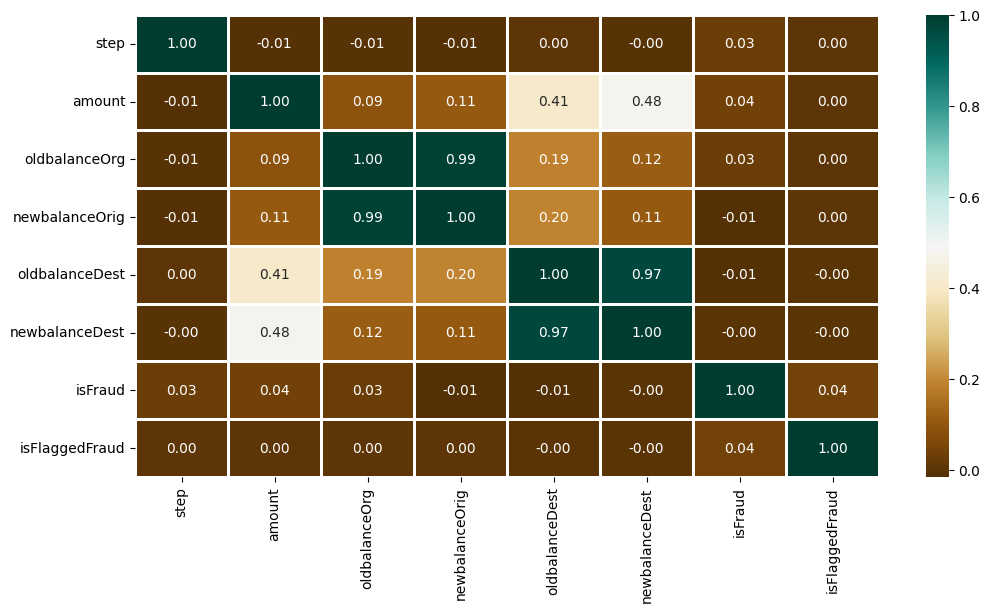

In [35]:
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), cmap='BrBG', fmt='.2f', linewidths=2, annot=True)

### Performing one-hot encoding for column type

In [3]:
type_new = pd.get_dummies(df['type'], drop_first=True)
df_new = pd.concat([df, type_new], axis=1)


In [7]:
output_directory = 'encoder/'
os.makedirs(output_directory, exist_ok=True)
encoder_filename = os.path.join(output_directory, 'df_new.pkl')
dump(df_new,encoder_filename)

['encoder/df_new.pkl']

In [37]:
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,True,False
1,1,PAYMENT,4501.30,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,True,False
2,1,TRANSFER,4501.30,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,True
3,1,CASH_OUT,4501.30,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,True,False


### Dropping unnecessary columns

In [8]:
X = df_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = df_new['isFraud']

In [39]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,True,False
1,1,4501.30,21249.0,19384.72,0.0,0.0,0,False,False,True,False
2,1,4501.30,181.0,0.00,0.0,0.0,0,False,False,False,True
3,1,4501.30,181.0,0.00,21182.0,0.0,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,True,False


In [40]:
X.shape, y.shape

((6362620, 11), (6362620,))

### Spilting the data

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

X_train.to_csv("data/X_train.csv",index=False)
X_test.to_csv("data/X_test.csv",index=False)
X_validation.to_csv("data/X_validation_test.csv",index=False)
y_train.to_csv("data/y_train.csv",index=False)
X_test.to_csv("data/X_train.csv",index=False)
y_validation.to_csv("data/y_validation_test.csv",index=False)

### Scaling

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [12]:
output_directory = 'scaling/'
os.makedirs(output_directory, exist_ok=True)
scaler_filename = os.path.join(output_directory, 'scaler.pkl')
dump(scaler, scaler_filename)

['scaling/scaler.pkl']

### XGBOOST

In [13]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
XGB.score(X_test,y_test)

0.9997872993620028

In [14]:
with open('models/xgb_model.pkl', 'wb') as file:
    pickle.dump(XGB, file)

### Logistic regression

In [15]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_train,y_train)
LR.score(X_test,y_test)

0.998553006989783

In [16]:
with open('models/logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(LR, file)

In [17]:
y_pred = XGB.predict(X)

### SVC

In [47]:
sample_size = 300000
num_rows, num_cols = X_train.shape
if sample_size > num_rows:
    sample_size = num_rows

sample_indices = np.random.choice(num_rows, sample_size, replace=False)
X_train_sampled = X_train.iloc[sample_indices]  # Select rows by indices
y_train_sampled = y_train.iloc[sample_indices]

# Define SVC with optimized parameters
svc_model = SVC(kernel='rbf', probability=True)

# Train the SVC model
svc_model.fit(X_train_sampled, y_train_sampled)

# Evaluate the model
train_preds = svc_model.predict_proba(X_train_sampled)[:, 1]
print('Support Vector Classifier:')
print('Training Accuracy:', ras(y_train_sampled, train_preds))


with open('models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

Support Vector Classifier:
Training Accuracy: 0.9347740075277282


### confusion matrix

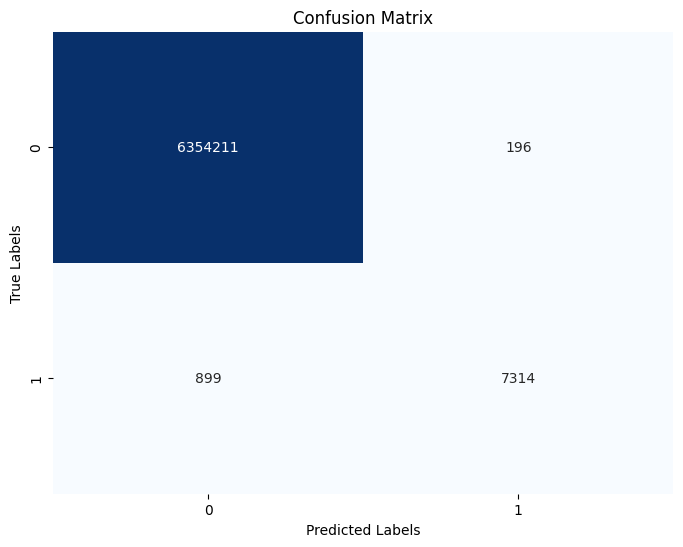

In [41]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()